# DAY 10: Bayesian model of regression


### Machine Learning and Computational Statistics (DSC6232)

#### Instructors: Weiwei Pan, Melanie Fernandez, Pavlos Protopapas

#### Due: August 6th, 2:00 pm Kigali Time

**First name**: _________________________________________________________


**Last name**: _____________

## Learning Goals:

1. understand the effect of priors and number of data observations on the posterior
2. understand how to interpret the posterior predictive 

### Load necessary libraries

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from autograd import scipy as sp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
%matplotlib inline

### We include auxiliary functions here that we will need to use later 

**No need to read in details!**

In [ ]:
def get_posterior_samples(prior_var, noise_var, x_matrix, y_matrix, x_test_matrix, samples=100):
  prior_variance = np.diag(prior_var * np.ones(x_matrix.shape[1]))
  prior_precision = np.linalg.inv(prior_variance)

  epsilon = 1e-5
  joint_precision = prior_precision + x_matrix.T.dot(x_matrix) / noise_var
  joint_variance = np.linalg.inv(joint_precision + epsilon * np.ones(x_matrix.shape[1])) 
  joint_mean = joint_variance.dot(x_matrix.T.dot(y_matrix)) / noise_var

  #sampling 100 points from the posterior
  posterior_samples = np.random.multivariate_normal(joint_mean.flatten(), joint_variance, size=samples)

  #take posterior predictive samples
  posterior_predictions = np.dot(posterior_samples, x_test_matrix.T) 
  posterior_predictive_samples = posterior_predictions + np.random.normal(0, noise_var**0.5, size=posterior_predictions.shape)

  return posterior_predictions, posterior_predictive_samples

def generate_data(number_of_points=10, noise_variance=0.5):
  #training x
  x = np.hstack((np.linspace(-10, -5, number_of_points), np.linspace(5, 10, number_of_points)))
  #function relating x and y
  f = lambda x:  0.01 * x**3
  #y is equal to f(x) plus gaussian noise
  y = f(x) + np.random.normal(0, noise_variance**0.5, 2 * N)
  x_test = np.linspace(-11, 11, 100)
  return x, y, x_test

## Build a Bayesian Model for Polynomial Regression
Recall that  a Bayesian model for polynomial regression has two pieces, the likelihood and the prior:
\begin{align}
y &= f_w(x) + \epsilon,\; \epsilon \sim \mathcal{N}(0, \sigma^2),\\
w &\sim \mathcal{N}(0, \sigma_w^2 I)
\end{align}
where $I$ is a $DxD$ identity matrix, and $D$ is the number of parameters in $f_w$.

The posterior of this Bayesian model $p(w | \mathrm{Data})$ gives us a **distribution over likely model parameters** for the data, and thus, a **distribution over models** for the data. The posterior predictive gives us a distribution over predictions for any input $x$.

**Exercise 1:** Explain the meaning of 0 in $\mathcal{N}(0, \sigma_w^2 I)$ in terms of prior beliefs about the model -- what do we believe about $w$? Explain $\sigma_w^2$ in terms of uncertainty in our prior beliefs about the model -- how confidence are we in our beliefs about $w$ if $\sigma_w^2=1$ or $\sigma_w^2 = 10$?

#### Let's generate some data

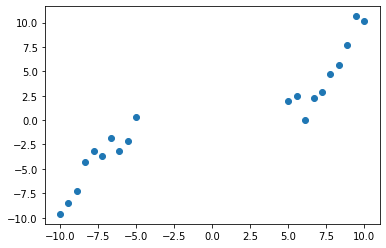

In [ ]:
# number of data points in each of the two segments of the domain
N = 10
# noise level in the data
noise_variance = 1.

# generate toy data
x_train, y_train, x_test = generate_data(number_of_points=N, noise_variance=noise_variance)
plt.scatter(x_train, y_train)

**Exercise 2:** Fit a Bayesian polynomial regression model of degree 15 to the small provided dataset. Visualize the posterior predictive. Using this visualization, summarize where the model is the most confident in its predictions and where it is least confident.

Can you explain why the model is not confident in certain places but confident in others?

In [ ]:
# Step 1: make an instance of the PolynomialFeatures model
poly = PolynomialFeatures(15)

# Step 2: fit our PolynomialFeatures to our data and add add polynomial powers to our covariates
x_train_poly = poly.fit_transform(x_train.reshape((-1, 1)))
x_test_poly = poly.fit_transform(x_test.reshape((-1, 1)))

In [ ]:
# Step 3: define the variance of the prior distribution
prior_variance = 1.
# Step 4: define the number of samples to take from the posterior
samples = 100

# Step 5: get samples from the posterior predictive
posterior_predictions, posterior_predictive_samples = get_posterior_samples(prior_variance, noise_variance, x_train_poly, y_train.reshape((-1, 1)), x_test_poly, samples)

In [ ]:
# Step 6: compute the 97.5 th percentile of the posterior predictive predictions
pp_upper = np.percentile(posterior_predictive_samples, 97.5, axis=0)

# Step 7: compute the 2.5 th percentile of the posterior predictive predictions
pp_lower = np.percentile(posterior_predictive_samples, 2.5, axis=0)

# Step 8: compute the 50 th percentile of the posterior predictive predictions
pp_mean = np.mean(posterior_predictive_samples, axis=0)

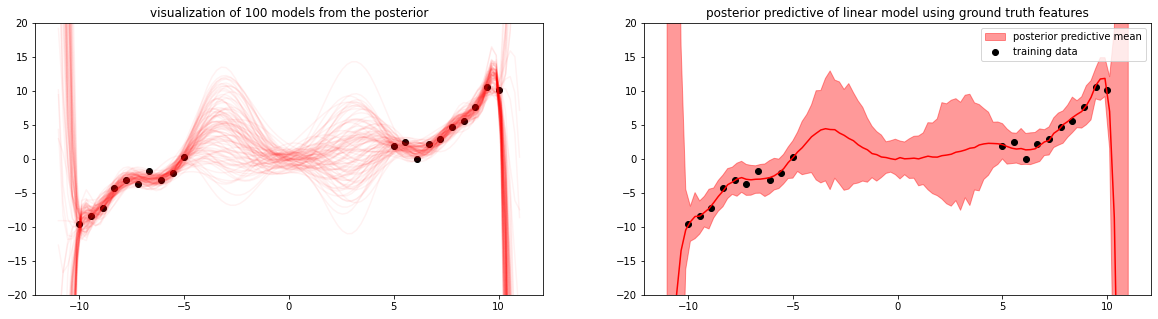

In [ ]:
# Step 9: Visualize the posterior predictive distribution
fig, ax = plt.subplots(1, 2, figsize=(20, 5))

# visualize the training data 
ax[0].scatter(x_train, y_train, color='black', label='training data') 

# visualize each model from the posterior
for sample in posterior_predictions:
    ax[0].plot(x_test, sample, color='red', alpha=0.05)

ax[0].set_ylim([-20, 20])
ax[0].set_title('visualization of {} models from the posterior'.format(samples))

# visualize the mean of the posterior predictive
ax[1].plot(x_test, pp_mean, color='red')
# visualize the 95% posterior predictive interval
ax[1].fill_between(x_test, pp_upper, pp_lower, color='red', alpha=0.4, label='posterior predictive mean')
# visualize the training data
ax[1].scatter(x_train, y_train, color='black', label='training data')

ax[1].legend(loc='best')
ax[1].set_title('posterior predictive of linear model using ground truth features')
ax[1].set_ylim([-20, 20])
plt.show()

**Exercise 3:** Change the prior variance $\sigma^2_w$ to 0.001 and visualize the posterior predictive. Change the prior variance $\sigma^2_w$ to 50 and visualize the posterior predictive. 

What is the effect of the prior variance on the posterior predictive? Why does the prior affect the posterior predictive in this way? Relate your answers to uncertainties.



**Exercise 4:** Change the number of data points $N$ in the dataset to 500 and visualize the posterior predictive. 

What is the effect of the number of data observations $N$ on the posterior predictive? Why does the number of data points $N$ affect the posterior predictive in this way? Support your answer with concepts from lecture.

**Exercise 5:** Change the noise variance $\sigma^2_y$ of the dataset to 10 and visualize the posterior predictive. Change the noise variance $\sigma^2_y$ of the dataset to 0.001 and visualize the posterior predictive. 

What is the effect of the noise variance $\sigma^2_y$ on the posterior predictive? Why does the noise variance $\sigma^2_y$ affect the posterior predictive in this way? Support your answer with concepts from lecture.